### Calculate a goodness of fit for individual gradient files.

In the next cell, we transform all of the gradient files into the same voxel space as the standard network maps from neurosynth.


In [1]:
% list files
indivfiles = dir(fullfile(pwd, 'data', 'Outputs', 'individual', '*npy0.nii'));
network_file = fullfile(pwd, 'ROIs_mask', 'dmn____pFgA_z_FDR_0.01.nii');

% transform into different voxel space
for i = 1:numel(indivfiles)
    gradient_file = fullfile(pwd, 'data', 'Outputs', 'individual', indivfiles(i).name);
    if ~exist(fullfile([gradient_file(1:end-4), 'transformed.nii']))
            MatlabFuncs.Transform_into_the_same_voxelspace(network_file, gradient_file);
    end
end

In the next cell, we use the different network files to calculate a goodness-of-fit (ratio between inside-of-the-network to outside-of-the-network).

In [2]:
%plot native
% define the inputs
mask_file = fullfile(pwd, 'ROIs_mask', 'rbgmask.nii');
network_files = dir(fullfile(pwd, 'ROIs_mask', '*FDR_0.01.nii*'));

% list the new, transformed files
transformfiles = dir(fullfile(pwd, 'data', 'Outputs', 'individual', '*transformed.nii'));

% reset the goodness of fit result
ratio = [];

for inetwork = 1:numel(network_files)
    
    % define network file for this loop
    network_file = fullfile(pwd, 'ROIs_mask', network_files(inetwork).name);
    
    % loop over participants
    for i = 1:numel(transformfiles)
        % update a progbar
        MatlabFuncs.progressbar(((inetwork-1)*numel(transformfiles)+i)/(numel(transformfiles)*numel(network_files)));
        % define gradient for this loop
        gradient_file = fullfile(pwd, 'data', 'Outputs', 'individual', transformfiles(i).name);
        % run the goodness-of-fit analysis
        [ratio(inetwork, i)] = MatlabFuncs.gradient_goodness(gradient_file, network_file, mask_file);
    end
end


Now, make one big vector that indexes what group people are in

In [32]:
phenodata = readtable(fullfile(pwd, 'data', 'Outputs', 'Phenotypic_V1_0b_preprocessed1.csv'));
for i = 1:numel(transformfiles)
    [~, loc] = ismember(transformfiles(i).name(4:end-34), phenodata.FILE_ID(:));
    if loc
        group(i) = phenodata.DX_GROUP(loc);
    else
        group(i) = NaN;
    end
end
disp(group(1:20))

  Columns 1 through 13

     1   NaN     1     1     2     2     2     2     2     2     2     1     2

  Columns 14 through 20

     1     1     2     2     1     1     1


In the next cell, I create a boxplot that ranks the networks by fit

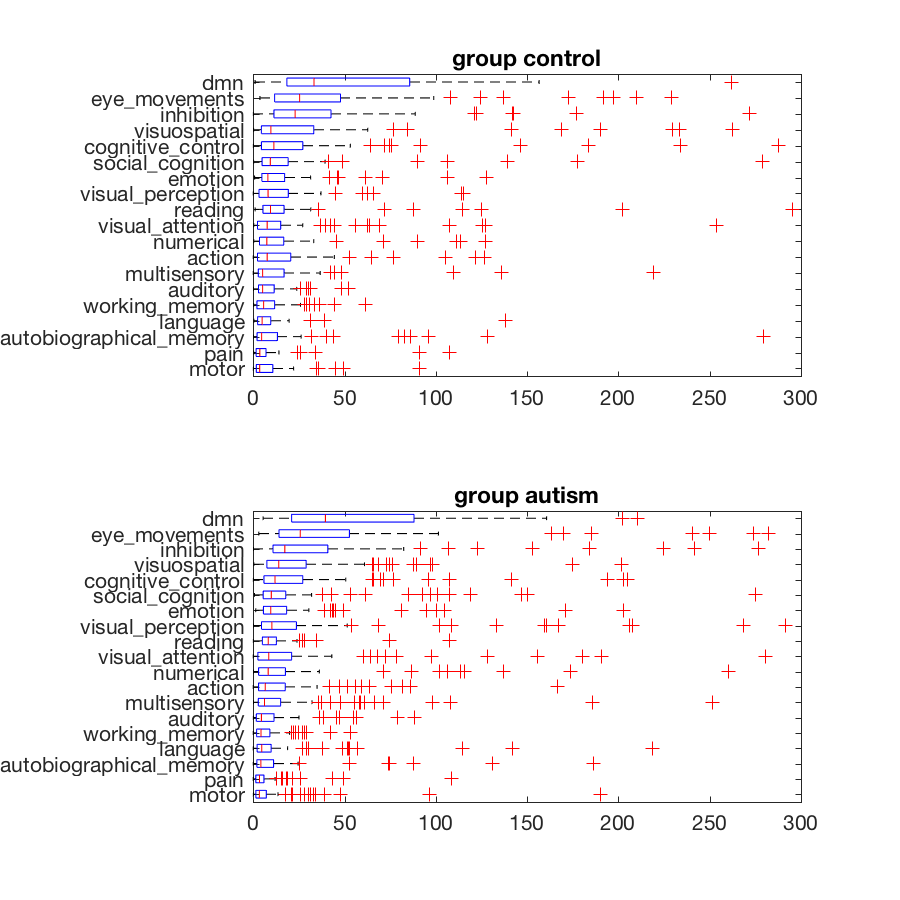

In [39]:
%plot inline -s 900,900
network_files = dir(fullfile(pwd, 'ROIs_mask', '*FDR_0.01.nii*'));
[~, sortorder] = sort(median(ratio, 2));
figure;
labels = {network_files(:).name};
for i = 1:numel(labels)
    labels{i} = labels{i}(1:end-23);
end

grouplabels = {'control', 'autism'};
for igroup = 1:2
    subplot(2, 1, igroup);
    boxplot((ratio(sortorder, group==igroup)'), 'orientation', 'horizontal', 'Label', labels(sortorder));
    xlim([0, 300]);
    xlabel()
    title(['group ', grouplabels{igroup}]);
end
% MatlabFuncs.xticklabel_rotate([1:inetwork],90,{network_files(:).name},'interpreter','none')